In [1]:
#importing libraries
import pandas as pd
import numpy as np
import os
from varname import nameof
import string
import nltk
from nltk.corpus import stopwords

#deep learning library
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras import optimizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
from keras.callbacks import CSVLogger
from tensorflow.python.keras.layers import Conv1D, Conv2D, MaxPooling1D, Flatten

seed = 1337

/Users/polinab/.virtualenvs/deep/lib/python3.8/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


### Import and explore data

In [2]:
yelp_labelled = pd.read_csv('yelp_labelled.txt', sep='\t', header=None)
yelp_labelled.columns = ['text', 'label']
yelp_labelled.head(5)

,text,label
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


<AxesSubplot:xlabel='label', ylabel='Count'>

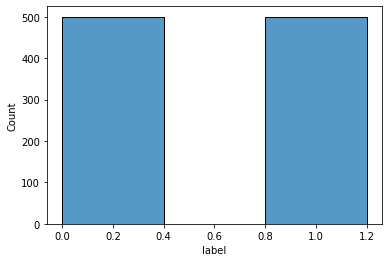

In [3]:
sns.histplot(data=yelp_labelled, x="label",bins=2,binwidth=0.4)


- 0 and 1 labels are equally distributed, so we do not need to resample the data
- 0 is a bad review, 1 is a good review
- small set of data, so we can use all of it

,text,label
226,This is an unbelievable BARGAIN!,1
129,Definitely worth venturing off the strip for t...,1
24,So they performed.,1
847,"In fact I'm going to round up to 4 stars, just...",1
554,"However, my recent experience at this particul...",0


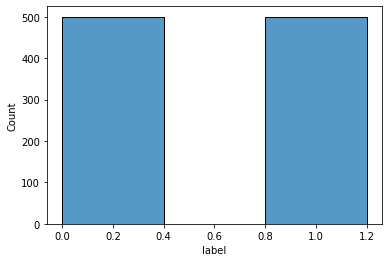

In [4]:
y = yelp_labelled['label']
train_df, test_df = train_test_split(yelp_labelled, test_size=0.2)
sns.histplot(data=yelp_labelled, x="label",bins=2,binwidth=0.4)
train_df.head()


### Vectorize the word data: building my own word dictionary
- a neural network model cannot interpret words, they need to be encoded into numbers
- external libraries exist that do this, like Word2Vec
- After playing around with the libraries I decided to make my own encoding to fully understand how the basics work
- getting rid of stop words made the model perform worse. Understandable since sequentially many of the stop words actually add information to the phrases! 

In [5]:
# separate into positive and negative posts
positive_posts = pd.Series.to_numpy(yelp_labelled[yelp_labelled.label == 1]['text'])
negative_posts = pd.Series.to_numpy(yelp_labelled[yelp_labelled.label == 0]['text'])

# keep an object with both sets for later use
posts = np.append(negative_posts, positive_posts, axis=0)

longest_post = max(len(post) for post in posts)
longest_post


149

In [6]:
def unique_words(lines):
    '''
    returns dictionary of unique words in input
    assigns an integer key to each word
    does not include punctuation or stop words 
    stop words can be removed or included depending on if it benefits the model
    '''
    unique_words = set()
    stop_words = set(stopwords.words('english'))

    for line in lines:
        for word in line:
#             if word not in stop_words:
#                 unique_words.add(word)
            unique_words.add(word)
    word_vals = set(i for i in range(len(unique_words)))
    word_keys = dict(zip(unique_words, word_vals))
    return word_keys

def word_to_vec(posts):
    '''
    encodes word input into integer arrays 
    stop words can be removed or included depending on the model
    '''
    stop_words = set(stopwords.words('english'))
    posts = [line.lower().translate(str.maketrans('', '', string.punctuation)).split(' ') for line in posts]
    word_dict = unique_words(posts)
    word_key_map = [[word_dict[word] for word in post] for post in posts]
#     word_key_map = [[word_dict[word] for word in post if word not in stop_words] for post in posts]
    return word_key_map

In [7]:
neg_encoded = word_to_vec(negative_posts)
pos_encoded = word_to_vec(positive_posts)
word_vecs = np.concatenate((neg_encoded, pos_encoded))
print(f'"{negative_posts[0]}" becomes {word_vecs[0]}')


"Crust is not good." becomes [88, 469, 1347, 20]


<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [8]:
# Padding the data samples to a maximum review length in words
longest_post = max([len(post) for post in word_to_vec(posts)])
padded_word_vecs = sequence.pad_sequences(word_vecs, maxlen=longest_post)


In [9]:
# re-create labels, concatenate with data, and set up test/train split
labels = np.concatenate((np.zeros(len(neg_encoded)), np.ones(len(pos_encoded))))
X_train, X_test, y_train, y_test = train_test_split(padded_word_vecs,labels,test_size=0.33)

print('X_train shape:', X_train.shape, y_train.shape)
print('X_test shape:', X_test.shape, y_test.shape)


X_train shape: (670, 32) (670,)
X_test shape: (330, 32) (330,)


#### Modularize model fitting and display functions
- I set up the following functions to avoid code redundancy and simplify the model evaluation process
- the functions allow for fitting, accuracy evaluation, and plotting of accuracy and loss over epochs

In [10]:

def fit_model(model, e, v, x_train, y_train, x_test, y_test):
    '''
    fits model over epochs and stores results in csv file
    '''
    csv_logger = CSVLogger(f"{nameof(model)}.csv", append=False)

    model.fit(
        x_train,
        y_train, 
        epochs=e, 
                   verbose=v,
                   callbacks=[csv_logger],
                   validation_data=(
                       x_test,
                       y_test))

def model_acc(model,x,y):
    scores = model.evaluate(x,y)
    return(scores[1])
    
def acc_graphs(model):
    '''
    displays accuracy and loss of model fit over epochs
    '''
    df = pd.read_csv(f"{nameof(model)}.csv")
    df.set_index('epoch', inplace=True)
    
    fig, ax =plt.subplots(1,2, figsize=(10, 5))
    df[['accuracy','val_accuracy']].plot(ax = ax[0])
    df[['loss','val_loss']].plot(ax = ax[1])

### Word-wise LSTM Model with custom embedding
LSTM is an artificial RNN architecture.
reference: https://towardsdatascience.com/a-beginners-guide-on-sentiment-analysis-with-rnn-9e100627c02e

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 32)            66560     
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 74,913
Trainable params: 74,913
Non-trainable params: 0
_________________________________________________________________
None
11/11 [==============================] - 0s 3ms/step - loss: 0.0361 - accuracy: 0.9879
Test accuracy: 0.9878787994384766


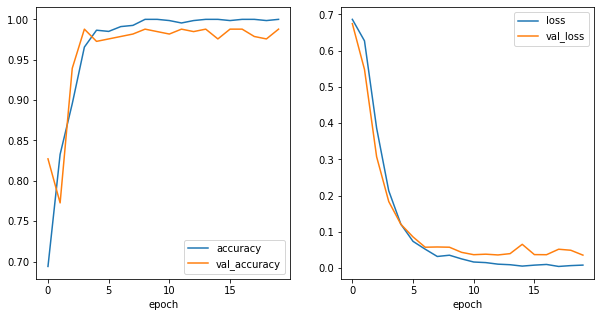

In [11]:
vocab_size = max([max(arr) for arr in word_to_vec(posts)])
embedding_size = 32
num_epochs = 20
lstm_model = Sequential()
lstm_model.add(Embedding(vocab_size, embedding_size, input_length=longest_post))
lstm_model.add(LSTM(embedding_size))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(1, activation='sigmoid'))
print(lstm_model.summary())

lstm_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

csv_logger = CSVLogger("lstm_model.csv", append=False)

fit_model(lstm_model, num_epochs,0,X_train, y_train,X_test,y_test)

print('Test accuracy:', model_acc(lstm_model,X_test, y_test))

acc_graphs(lstm_model)


### Word-wise CNN Model with custom embedding
https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 32, 50)            104000    
_________________________________________________________________
conv1d (Conv1D)              (None, 25, 50)            20050     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 12, 50)            0         
_________________________________________________________________
flatten (Flatten)            (None, 600)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                6010      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 130,071
Trainable params: 130,071
Non-trainable params: 0
________________________________________________

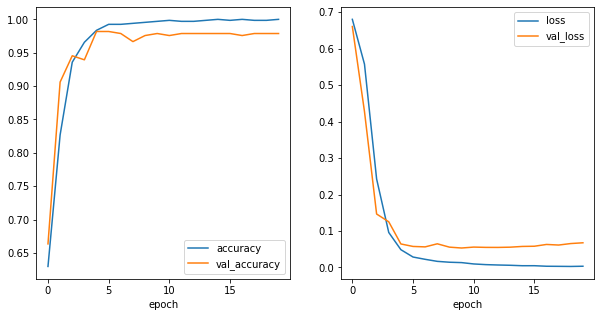

In [12]:
embedding_size = 50
cnn_model = Sequential()
cnn_model.add(Embedding(vocab_size, embedding_size, input_length=longest_post))
cnn_model.add(Conv1D(embedding_size,kernel_size=8, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(10, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))
cnn_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(cnn_model.summary())

fit_model(cnn_model, num_epochs,0,X_train, y_train,X_test,y_test)

print('Test accuracy:', model_acc(cnn_model,X_test, y_test))

acc_graphs(cnn_model)


##### Problems with this approach:
- after coding this section, I realized that using the entire set to build the embedding dictionary is "cheating": in the real world, we would not have access to the test data
- I decided to see how much the results would be affected by separating train and test data before building the dictionary
- unfortunately, the results were much worse. This makes sense because missing words would have no assocation to a label
- this is why we want to use similarity vectors for words.
- as you can see below, the in-sample accuracy converges to nearly 1, while the validation accuracy hovers around 50%
- below, you can see how my custom-dictionary model fails when the dictionary is built only with training data

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


X_train shape: (800, 149) (800,)
X_test shape: (200, 149) (200,)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 32, 32)            66560     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 74,913
Trainable params: 74,913
Non-trainable params: 0
_________________________________________________________________
None
7/7 [==============================] - 0s 13ms/step - loss: 1.3844 - accuracy: 0.5600
Test accuracy: 0.5600000023841858


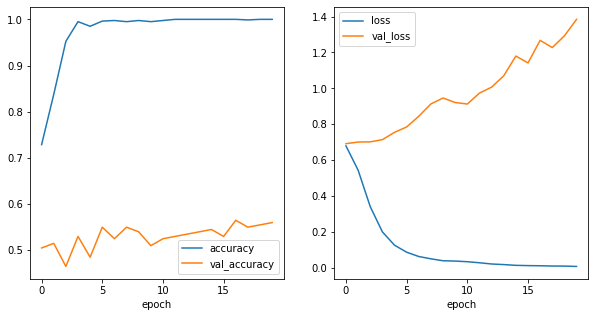

In [13]:
def preprocess(df):
    # separate into positive and negative posts
    positive_posts = pd.Series.to_numpy(df[df.label == 1]['text'])
    negative_posts = pd.Series.to_numpy(df[df.label == 0]['text'])

    # keep an object with both sets for later use
    posts = np.append(negative_posts, positive_posts, axis=0)
    
    neg_encoded = word_to_vec(negative_posts)
    pos_encoded = word_to_vec(positive_posts)
    word_vecs = np.concatenate((neg_encoded, pos_encoded))
    
    # Padding the data samples to a maximum review length in words
#     longest_post = max([len(post) for post in word_to_vec(posts)])
    padded_word_vecs = sequence.pad_sequences(word_vecs, maxlen=149)
    
    labels = np.concatenate((np.zeros(len(neg_encoded)), np.ones(len(pos_encoded))))
    
    return padded_word_vecs,labels

X_train, y_train = preprocess(train_df)
X_test, y_test = preprocess(test_df)

print('X_train shape:', X_train.shape, y_train.shape)
print('X_test shape:', X_test.shape, y_test.shape)

vocab_size = max([max(arr) for arr in word_to_vec(posts)])
embedding_size = 32
lstm_model = Sequential()
lstm_model.add(Embedding(vocab_size, embedding_size, input_length=longest_post))
lstm_model.add(LSTM(embedding_size))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(1, activation='sigmoid'))
print(lstm_model.summary())

lstm_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

fit_model(lstm_model, num_epochs,0,X_train, y_train,X_test,y_test)

print('Test accuracy:', model_acc(lstm_model,X_test, y_test))

acc_graphs(lstm_model)


### Create word-wise GloVe pre-trained embeddings
Re-doing the character-wise model with GloVe pre-trained embeddings, since the custom dictionary approach fails when applied on training set only.

In [14]:

class wordVec:
    '''
    generates a split of training and test data in class format.
    useful when dealing with many sets of data in different splits 
    '''
    def __init__(self, data):
        self.samples = pd.Series.to_numpy(data.text)
        self.labels = pd.Series.to_numpy(data.label)
        
        self.train_samples = None
        self.val_samples = None
        
        self.train_labels = None
        self.val_labels = None

    def split(self, n):
        rng = np.random.RandomState(seed)
        rng.shuffle(self.samples)
        rng = np.random.RandomState(seed)
        rng.shuffle(self.labels)

        # Extract a training & validation split
        validation_split = n
        num_validation_samples = int(validation_split * len(self.samples))
        self.train_samples = self.samples[:-num_validation_samples]
        self.val_samples = self.samples[-num_validation_samples:]
        self.train_labels = self.labels[:-num_validation_samples]
        self.val_labels = self.labels[-num_validation_samples:]

In [15]:
# Split to train and test

yelp_labelled = pd.read_csv('yelp_labelled.txt', sep='\t', header=None)
yelp_labelled.columns = ['text', 'label']

yelpVec = wordVec(yelp_labelled)
yelpVec.split(0.2)
yelpVec.train_samples[0]


'Overpriced for what you are getting.'

In [16]:
#Tokenize the sentences
tokenizer = Tokenizer()

#preparing vocabulary
tokenizer.fit_on_texts(list(yelpVec.train_samples))

#converting text into integer sequences
x_tr_seq  = tokenizer.texts_to_sequences(yelpVec.train_samples) 
x_val_seq = tokenizer.texts_to_sequences(yelpVec.val_samples) 

#padding to prepare sequences of same length
x_tr_seq  = pad_sequences(x_tr_seq, maxlen=100)
x_val_seq = pad_sequences(x_val_seq, maxlen=100)

size_of_vocabulary=len(tokenizer.word_index) + 1 #+1 for padding
print(size_of_vocabulary)

1816


In [17]:
X_train = np.array(x_tr_seq),
y_train = np.array(yelpVec.train_labels)

X_test = np.array(x_val_seq),
y_test = np.array(yelpVec.val_labels)


In [18]:
def load_pretrained():
    path_to_glove_file = os.path.join(
        os.path.expanduser("~"), ".keras/datasets/glove.6B.300d.txt")

    embeddings_index = {}
    with open(path_to_glove_file) as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs

    print("Found %s word vectors." % len(embeddings_index))
    return embeddings_index

In [19]:
embed_index = load_pretrained()

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((size_of_vocabulary, 300))

for word, i in tokenizer.word_index.items():
    embedding_vector = embed_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


Found 400000 word vectors.


### Word-Wise LSTM model using GloVe embeddings

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 300)          544800    
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 128)          219648    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
_________________________________________________________________
flatten_1 (Flatten)          (None, 1)                 0         
Total params: 772,769
Trainable params: 227,969
Non-trainable params: 544,800
__________________________________________

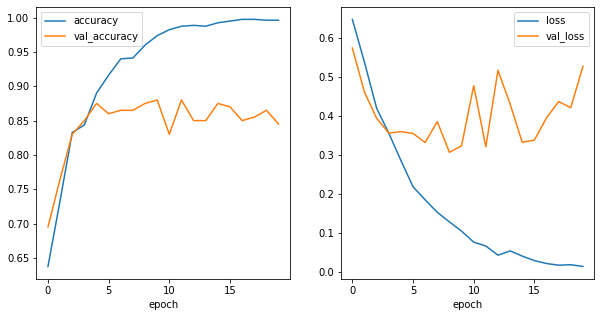

In [20]:
embedding_size = 50
lstm_glove_model = Sequential()
lstm_glove_model.add(Embedding(size_of_vocabulary,300,weights=[embedding_matrix],input_length=100,trainable=False))
lstm_glove_model.add(LSTM(128,return_sequences=True,dropout=0.2))
lstm_glove_model.add(GlobalMaxPooling1D())
lstm_glove_model.add(Dense(64,activation='relu')) 
lstm_glove_model.add(Dense(1,activation='sigmoid')) 
lstm_glove_model.add(Flatten())
lstm_glove_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(lstm_glove_model.summary())

num_epochs = 20
fit_model(lstm_glove_model, num_epochs,0,X_train, y_train,X_test,y_test)

print('Test accuracy:', model_acc(lstm_glove_model,X_test, y_test))

acc_graphs(lstm_glove_model)


### Word-wise CNN using GloVe embeddings

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 300)          544800    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 93, 50)            120050    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 46, 50)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2300)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                115050    
_________________________________________________________________
dense_7 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_8 (Dense)              (None, 5)                

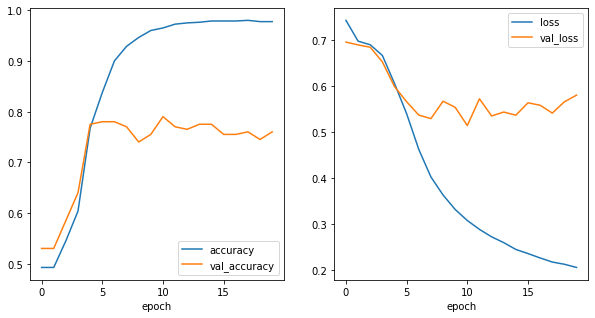

In [21]:
embedding_size = 50
cnn_glove_model = Sequential()
cnn_glove_model.add(Embedding(size_of_vocabulary,300,weights=[embedding_matrix],input_length=100,trainable=False))
cnn_glove_model.add(Conv1D(embedding_size,kernel_size=8, activation='relu'))
cnn_glove_model.add(MaxPooling1D(pool_size=2))
cnn_glove_model.add(Flatten())
cnn_glove_model.add(Dense(50, activation='sigmoid'))
cnn_glove_model.add(Dense(10, activation='relu'))
cnn_glove_model.add(Dense(5, activation='sigmoid'))
cnn_glove_model.add(Dense(1, activation='sigmoid'))
cnn_glove_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(cnn_glove_model.summary())

fit_model(cnn_glove_model, num_epochs,0,X_train, y_train,X_test,y_test)

print('Test accuracy:', model_acc(cnn_glove_model,X_test, y_test))

acc_graphs(cnn_glove_model)


### Prepare and vectorize the character-wise data

In [22]:
def char_tokenizer(lines):
    tk = Tokenizer(num_words=None, char_level=True, oov_token='UNK')
    lines_low = [[l.lower() for l in lines]]
    tk.fit_on_texts(lines_low)

    alphabet = "abcdefghijklmnopqrstuvwxyz0123456789,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]{}"
    char_dict = {}
    for i, char in enumerate(alphabet):
        char_dict[char] = i + 1

    # Use char_dict to replace the tk.word_index
    tk.word_index = char_dict.copy()
    # Add 'UNK' to the vocabulary
    tk.word_index[tk.oov_token] = max(char_dict.values()) + 1
    return tk

In [23]:
def embed_weights(tk):
    vocab_size = len(tk.word_index)
    embedding_weights = []
    embedding_weights.append(np.zeros(vocab_size))

    for char,i in tk.word_index.items():
        onehot = np.zeros(vocab_size)
        onehot[i-1] = 1
        embedding_weights.append(onehot)

    return np.array(embedding_weights)

In [24]:
# transform reviews into character encodings:

posts = positive_posts + negative_posts
tk = char_tokenizer(posts)
vocab_size = len(tk.word_index)
pos_seqs = tk.texts_to_sequences(positive_posts)
neg_seqs = tk.texts_to_sequences(negative_posts)
print(f'{positive_posts[0]} becomes {pos_seqs[0]}')

Wow... Loved this place. becomes [23, 15, 23, 39, 39, 39, 69, 12, 15, 22, 5, 4, 69, 20, 8, 9, 19, 69, 16, 12, 1, 3, 5, 39]


In [25]:
longest_post = max([len(x) for x in np.append(neg_seqs, pos_seqs, axis=0)])
print(f'longest post is {longest_post} characters long')

longest post is 149 characters long


/Users/polinab/.virtualenvs/deep/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [26]:
# pad data:

pos_seq_padded = pad_sequences(pos_seqs, maxlen=longest_post, padding='post')
neg_seq_padded = pad_sequences(neg_seqs, maxlen=longest_post, padding='post')

pos_data = np.array(pos_seq_padded, dtype='float32')
neg_data = np.array(neg_seq_padded, dtype='float32')
pos_data[0]

array([23., 15., 23., 39., 39., 39., 69., 12., 15., 22.,  5.,  4., 69.,
       20.,  8.,  9., 19., 69., 16., 12.,  1.,  3.,  5., 39.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

In [27]:
padded_char_vecs = np.append(neg_data, pos_data, axis = 0)

labels = np.concatenate((np.zeros(len(neg_data)), np.ones(len(pos_data))))
X_train_char, X_test_char, y_train_char, y_test_char = train_test_split(padded_char_vecs, labels, test_size=0.33)

print('X_train_char shape:', X_train_char.shape, y_train_char.shape)
print('X_test_char shape:', X_test_char.shape, y_test_char.shape)

X_train_char shape: (670, 149) (670,)
X_test_char shape: (330, 149) (330,)


In [28]:
# define embedding layer 
def embed_weights(tk):
    vocab_size = len(tk.word_index)
    embedding_weights = []
    embedding_weights.append(np.zeros(vocab_size))

    for char,i in tk.word_index.items():
        onehot = np.zeros(vocab_size)
        onehot[i-1] = 1
        embedding_weights.append(onehot)

    return np.array(embedding_weights)

In [29]:
embedding_size = 69 #TODO: find where this number comes from
input_size = longest_post
em_weights = embed_weights(tk)
embedding_layer = Embedding(vocab_size+1,embedding_size,input_length=input_size,weights=[em_weights])


###  Character-wise CNN model
https://realpython.com/python-keras-text-classification/

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 149, 69)           4830      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 142, 69)           38157     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 69)                0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 69)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                700       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 11        
Total params: 43,698
Trainable params: 43,698
Non-trainable params: 0
__________________________________________________

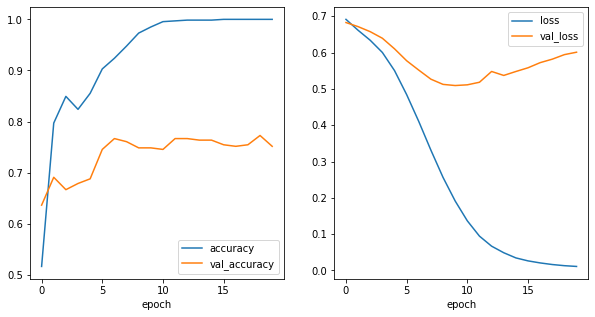

In [30]:
cnn_char_model = Sequential()
cnn_char_model.add(embedding_layer)
cnn_char_model.add(Conv1D(embedding_size, kernel_size=8, activation='relu'))
cnn_char_model.add(GlobalMaxPooling1D())

cnn_char_model.add(Flatten())
cnn_char_model.add(Dense(10, activation='relu'))
cnn_char_model.add(Dense(1, activation='sigmoid'))
cnn_char_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(cnn_char_model.summary())

fit_model(cnn_char_model, num_epochs,0,
          X_train_char, y_train_char,
          X_test_char,y_test_char)

print('Test accuracy:', model_acc(cnn_char_model,X_test_char, y_test_char))

acc_graphs(cnn_char_model)


### Conclusions

#### Embeddings
Out of the four models I tried, LSTM using GloVe embeddings led to the best results. I did have even better results with LSTM using a custom word dictionary, but I had to discard those results after I realized that training the dictionary on the full set was not appropriate to a real-life use case. In a real machine learning scenario, I would not have access to the test data and I would not be able to construct a dictionary using information from the test set. Since this data set was small, and ever review contained different vocabulary, not including the test set in the training dictionary led to a lot of unmatched words. If the set of data contained less variability among words between train and test sets, the results of the custom dictionary could have been improved. <br>
I found very good results using the GloVe pre-trained word embeddings. I used the 300-dimensional ones, which I believe allowed for more information to be used by the model that a lower dimension. I also tried word2vec embeddings chose to go with GloVe in the end due to ease of use. Since GloVe uses a pre-existing large body of words, it does not depend as much on the information in the input data.

#### Choice of model
When comparing the word vector approach, LSTMs performed better than CNNs. Furthermore, I found that an LSTM model performed better than a regular RNN, but the regular RNN also performed about as well as a CNN. LSTMs retain more imformation over time than RNNs through the use of additional "memory cell" units (Chung et al 2014), which allow better improvements over multiple epochs. <br>RNNs perform better than CNNs when the input data contains longer, semantically complicated sentences (Yin et al 2017). This makes sense because RNNs are usually used for predicting sequences, while CNNs were originally used on images and explore spatial correlation of data points. When a sentence needs to be parsed semantically, I would expect an RNN to perform better. However, if detection of specific features is more important, then I would choose a CNN. 


#### Hyperparameters and layers
While I did not do a full hyperparameter grid search integration, I did explore a few combinations of layers and hyperparameters when building my models. Out of what I explored, here is what I found the biggest improvements with:
- max pooling layer : dimensionality reduction. This had the greatest effect on increasing accuracy.
- adding more dense layers with numbers of neurons between 5 and 50 : models with 2-3 layers performed slightly better than single-layer
- combining a relu with a sigmoid layer in the stack, instead of only using one kind or the other. I also tried softmax and tanh activation functions, but they did not yield better results.
- hidden size and batch size adjustments, but no clear trend on which works better.


#### Future improvements

If I had more time, I would focus on looking into the input layer of the model and the dimensions of the data I am passing it. <br>
If I were to continue this project, I would also build a hyperparameter grid search for my successful models. This way, I would be able to automate the process of tuning hyperparameters instead of trying different numbers manually. Ideally, I would find a way to explore different numbers of layers as well. <br>
Finally, I would explore stacking a convolutional layer with an LSTM layer. When I was exploring different architectures I found many references to combined models with CNN and LSTM (Friedrich et al 2020), and I would expect good results in this use case.

#### Reference Papers
- http://www.shl-dataset.org/wp-content/uploads/SHLChallenge2020/short_videos_presentations/01_ubicomp20q-sub1022-cam-i7.pdf
- https://arxiv.org/pdf/1702.01923.pdf
- https://arxiv.org/abs/1412.3555